<a href="https://colab.research.google.com/github/DrSnach/GLUE-Benchmark/blob/master/0_Validation_test_imbd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

from time import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [4]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='imdb_reviews', split=('train[:60%]', 'train[60%:]'), batch_size=-1)

In [5]:
train_data.keys()

dict_keys(['label', 'text'])

In [6]:
df_train = pd.DataFrame(data=train_data)
df_val = pd.DataFrame(data=validation_data)

In [7]:
df_train.text

0        b"This was an absolutely terrible movie. Don't...
1        b'I have been known to fall asleep during film...
2        b'Mann photographs the Alberta Rocky Mountains...
3        b'This is the kind of film for a snowy Sunday ...
4        b'As others have mentioned, all the women that...
                               ...                        
14995    b"I saw this movie in 1979, I was 17 or 18, wh...
14996    b'The only reason I give this movie an 8 out o...
14997    b"I saw this movie in my childhood. And after ...
14998    b"COULD CONTAIN SPOILERS.....I'm surprised by ...
14999    b'Long, boring, blasphemous. Never have I been...
Name: text, Length: 15000, dtype: object

In [8]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  
 

In [9]:
# Transform data to string as it came as tensor object. Cleans data

sentence = process_data(df_train.text.apply(str))
label = df_train.label.apply(int)
print(len(sentence))
print(len(label))

15000
15000


In [10]:
label

0        0
1        0
2        0
3        1
4        1
        ..
14995    0
14996    1
14997    1
14998    0
14999    0
Name: label, Length: 15000, dtype: int64

In [11]:
sentence

0         This was an absolutely terrible movie  Don't ...
1         I have been known to fall asleep during films...
2         Mann photographs the Alberta Rocky Mountains ...
3         This is the kind of film for a snowy Sunday a...
4         As others have mentioned  all the women that ...
                               ...                        
14995     I saw this movie in 1979  I was 17 or 18  whe...
14996     The only reason I give this movie an 8 out of...
14997     I saw this movie in my childhood  And after 1...
14998     COULD CONTAIN SPOILERS     I'm surprised by t...
14999     Long  boring  blasphemous  Never have I been ...
Name: text, Length: 15000, dtype: object

In [12]:
# Transform data to string for validation as well

# val_sentence = process_data(df_val.sentence.apply(str))
# val_label = df_val.label
# print(len(val_sentence))
# print(len(val_label))

In [13]:
# Check lenght of sentence

count = sentence.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 241.133733
Median: 180.000000
Max: 2527.000000


In [14]:
# Brings Tokenizer and sequences padder

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=20000)
max_len = 250

In [15]:
# Creates vocabulary with all unique tokens

#tokenizer.fit_on_texts(list(sentence) + list(val_sentence))
tokenizer.fit_on_texts(sentence)

vocab_size = len(tokenizer.word_index) + 1 # Because it counts from 0
print(vocab_size)

67600


In [16]:
# transforms sentences into integers and pads to maxlen

encoded_sentences = tokenizer.texts_to_sequences(sentence)
padded_sentences = pad_sequences(encoded_sentences, maxlen=max_len, padding='post')

# Check
print(sentence[0])
print(encoded_sentences[0])
print(padded_sentences[0])

 This was an absolutely terrible movie  Don't be lured in by Christopher Walken or Michael Ironside  Both are great actors  but this must simply be their worst role in history  Even their great acting could not redeem this movie's ridiculous storyline  This movie is an early nineties US propaganda piece  The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions  Maria Conchita Alonso appeared phony  and her pseudo love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning  I am disappointed that there are movies like this  ruining actor's like Christopher Walken's good name  I could barely sit through it  
[11, 13, 34, 450, 382, 16, 173, 28, 9062, 8, 32, 1329, 3663, 40, 523, 10816, 197, 25, 85, 156, 18, 11, 206, 335, 28, 69, 243, 215, 8, 485, 61, 69, 85, 115, 97, 23, 6175, 11, 3413, 685, 781, 11, 16, 6, 34, 411, 7867, 177, 2411, 424, 1, 90, 1176, 137, 71, 147, 54, 1, 7489, 71, 225, 69, 305

In [17]:
# # Same for validation

# val_encoded_sentences = tokenizer.texts_to_sequences(val_sentence)
# val_padded_sentences = pad_sequences(val_encoded_sentences, maxlen=max_len, padding='post')

# # Check
# print(val_sentence[0])
# print(val_encoded_sentences[0])
# print(val_padded_sentences[0])

In [18]:
# # download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [19]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
# lists files

!ls "/content/gdrive/My Drive/glove.6B.100d.txt"

'/content/gdrive/My Drive/glove.6B.100d.txt'


In [21]:
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [22]:
# Start with the embedding. Randomly initializing the zeros

embedding_dimensions = 100

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector  

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout1D
from keras import layers

In [47]:
embed = Embedding(vocab_size,embedding_dimensions,weights=[embedding_matrix],input_length=max_len, trainable=False)

n_hidden = 16


In [48]:
model = Sequential()
model.add(embed)
#model.add(SpatialDropout1D(rate=0.2))
#model.add(Activation('sigmoid'))
model.add(LSTM(n_hidden, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          6760000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,767,505
Trainable params: 7,505
Non-trainable params: 6,760,000
_________________________________________________________________


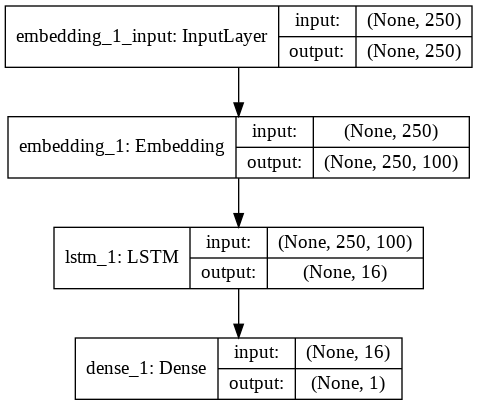

In [49]:
# Plot model graph
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
# model = Sequential()
# model.add(embed)
# model.add(layers.Conv1D(64, 5, activation='relu')) 
# #model.add(LSTM(n_hidden))
# #model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(layers.GlobalMaxPooling1D())
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [51]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
# Classs is imbalanced!! If not addressed the model finds a local minimum at 70
# by adscribing 1 to every example and thus acquiring 70% accuracy

#class_weights = {(0, 1):3, (1, 0):7}

#class_weights= {0:3, 1:7}

In [52]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(padded_sentences,
                    label,                    
                    epochs=5,
                    batch_size=32,
                    #class_weight=class_weights,                    
                    validation_split = 0.2,
                    verbose=True,                    
                    callbacks=[earlystop])

Train on 12000 samples, validate on 3000 samples
Epoch 1/5
12000/12000 [==============================] - 163s 14ms/step - loss: 0.6799 - accuracy: 0.5324 - val_loss: 0.6728 - val_accuracy: 0.5717
Epoch 2/5
12000/12000 [==============================] - 159s 13ms/step - loss: 0.5971 - accuracy: 0.6563 - val_loss: 0.4635 - val_accuracy: 0.7997
Epoch 3/5
12000/12000 [==============================] - 156s 13ms/step - loss: 0.4705 - accuracy: 0.7862 - val_loss: 0.3919 - val_accuracy: 0.8317
Epoch 4/5
12000/12000 [==============================] - 153s 13ms/step - loss: 0.4334 - accuracy: 0.8036 - val_loss: 0.3784 - val_accuracy: 0.8357
Epoch 5/5
12000/12000 [==============================] - 152s 13ms/step - loss: 0.4234 - accuracy: 0.8112 - val_loss: 0.3693 - val_accuracy: 0.8457


In [45]:
K.clear_session()


In [ ]:

# results = model.evaluate(val_padded_sentences, val_label)

# print(results)

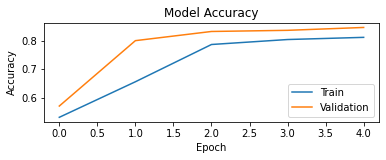

In [55]:
import seaborn as sns

# Plot Accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')